In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os, sys

from collections import Counter

In [159]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
data_folder = "../data/paco-cheese"
data_path = {
    'rnn_context': os.path.join(data_folder, "pc_rnn3_c.csv"), # trained with context
    'gpt_context': os.path.join(data_folder, "pc_gpt1_c.csv"), # trained withOUT context, predicted with
}

In [3]:
df = {}
for k,v in data_path.items():
    tmp = pd.read_csv(v)
    tmp['model'] = k
    df[k] = tmp

res = pd.concat(df.values(), axis=0)

In [4]:
res.head()

,corpus,speaker,file,dyad,start,stop,text,theme,index,has_theme,context_5,con+text,normalised_h,length,tokens_h,sum_h,xu_h,model
0,cheese,AA,Cheese-AA_OR,AAOR,4.54,4.83993,tu as,hetero selection,0,True,NaN,tu as,11.470525,2,"[-10.600510597229004, -12.34053897857666]",22.941050,0.926246,rnn_context
1,cheese,OR,Cheese-AA_OR,AAOR,5.14,5.82492,mh ouais si tu veux,hetero selection,1,True,tu as,tu as mh ouais si tu veux,10.208564,7,"[-9.780264854431152, -14.743060111999512, -10....",71.459950,0.822751,rnn_context
2,cheese,OR,Cheese-AA_OR,AAOR,6.62,7.00991,frog joke,Lecture frog joke OR,2,True,tu as mh ouais si tu veux,tu as mh ouais si tu veux frog joke,16.334092,4,"[-11.227624893188477, -20.28472900390625, -14....",65.336368,1.259988,rnn_context
3,cheese,OR,Cheese-AA_OR,AAOR,7.42,10.86995,un jour un ingénieur traversait la rue quand u...,Lecture frog joke OR,3,True,tu as mh ouais si tu veux frog joke,tu as mh ouais si tu veux frog joke un jour un...,11.881809,16,"[-7.411549091339111, -11.682819366455078, -7.7...",190.108944,0.985153,rnn_context
4,cheese,OR,Cheese-AA_OR,AAOR,11.36,13.83519,si tu m'embrasses je me transforme en belle pr...,Lecture frog joke OR,4,True,tu as mh ouais si tu veux frog joke un jour un...,tu as mh ouais si tu veux frog joke un jour un...,10.313206,12,"[-4.488735198974609, -4.985265731811523, -12.6...",123.758475,0.868723,rnn_context


In [6]:
length_by_file = res.groupby('file')['index'].max().to_dict()

## Plots
### Generals

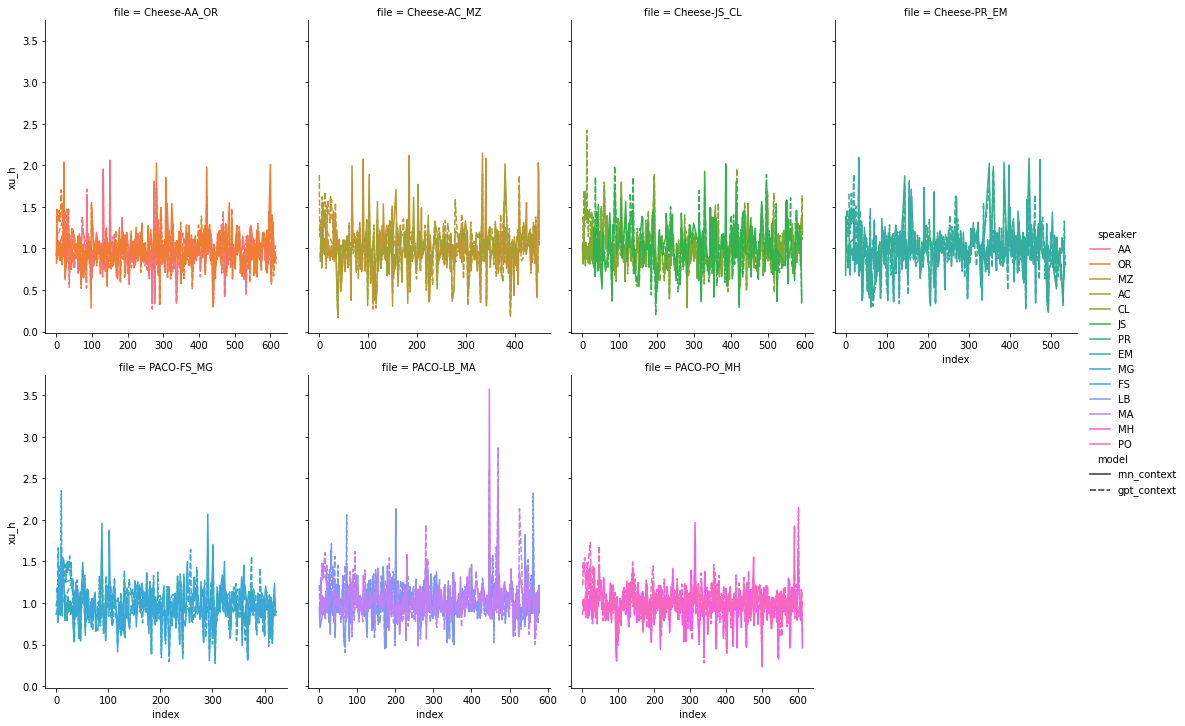

In [7]:
sns.relplot(
    data=res,
    x="index", y="xu_h",
    hue="speaker", col="file", col_wrap=4, style='model',
    kind="line", 
    height=5, aspect=.75, facet_kws=dict(sharex=False),
)

### By episodes

In [73]:
dialogs = res #df['rnn_context']

Number of themes by file?

/Users/neako/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

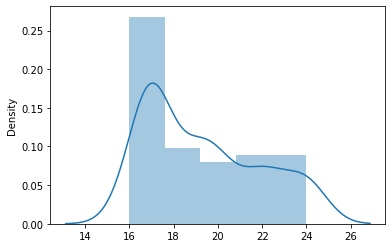

In [137]:
sns.distplot(dialogs.drop_duplicates(subset=['file','theme']).groupby('file').count())

In [74]:
# For the 2nd one: reindex => take the sign * max number
# Remove lines with extra transitions then for each one take the lines before / after and index and concat
# Note: issue with duplicated themes
not_transition = (dialogs.theme != 'transition').astype(int)
#dialogs = dialogs[dialogs.theme != 'transition']
dialogs['theme_index'] = (dialogs.theme != dialogs.theme.shift()).cumsum()
nb_in_ep = dialogs.groupby(['file', 'theme_index']).agg({'index': lambda x: range(len(x))}).explode('index')['index'].to_list()
inv_nb_in_ep = dialogs.groupby(['file', 'theme_index']).agg({'index': lambda x: range(-len(x),0)}).explode('index')['index'].to_list()
dialogs['count_after'] = nb_in_ep * not_transition
dialogs['count_before'] =  inv_nb_in_ep * not_transition

In [149]:
def compute_transitions_df(dialogs:pd.DataFrame, min_idx:int=10, max_idx:int=40):
    # TODO: add checks on columns
    # remove_transitions
    dialogs = dialogs[dialogs.theme != 'transition'].reset_index(drop=True)
    # get lines with 0
    new_themes = dialogs[dialogs.count_after == 0]
    new_themes['theme_index'] = range(new_themes.shape[0])

    final_df = []
    for idx, row in new_themes.iterrows():
        tmp = dialogs.iloc[max(0,idx-min_idx):min(dialogs.shape[0],idx+max_idx)]
        tmp['index'] = range(max(-min_idx,-idx), min(max_idx,dialogs.shape[0] - idx))
        # no need to check on file / model, done automatically
        tmp['ba'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else x.count_before, axis=1)
        tmp = tmp[tmp['index'] == tmp.ba]
        tmp['theme_index'] = row.theme_index
        # Add for plotting
        tmp['count_after'] = tmp.apply(lambda x: x.count_after if x['index'] >= 0 else np.nan, axis=1)
        tmp['count_before'] = tmp.apply(lambda x: x.count_before if x['index'] <= 0 else np.nan, axis=1)
        # Add initiator / responder
        tmp['is_initiator'] = (tmp.speaker == row.speaker)
        # Add to df
        final_df.append(tmp)

    final_df = pd.concat(final_df, ignore_index=True)
    final_df['is_initiator'] = final_df.is_initiator.apply(lambda x: x * 'initiator' + (1 - x) * 'responder')
    return final_df

In [150]:
final_df = compute_transitions_df(dialogs, max_idx=20)
final_df.shape

/Users/neako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/neako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/neako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

(6309, 23)

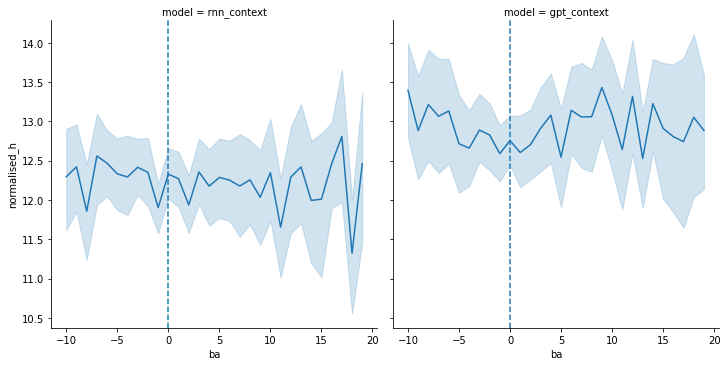

In [124]:
g = sns.relplot(data=final_df, x="ba", y="normalised_h", kind="line", col='model')
for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')

Differenciating between initiators and responders 

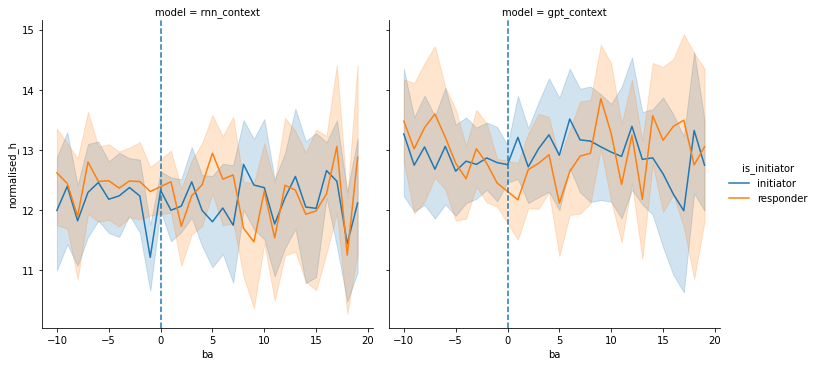

In [151]:
g = sns.relplot(data=final_df, x="ba", y="normalised_h", kind="line", col='model', hue='is_initiator')
for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')

Graph we want: apply `statsmodel` _before 0_ and _after 0_ and plot it on the same graph (with a scatterplot for the values)

/Users/neako/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/neako/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/neako/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/neako/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


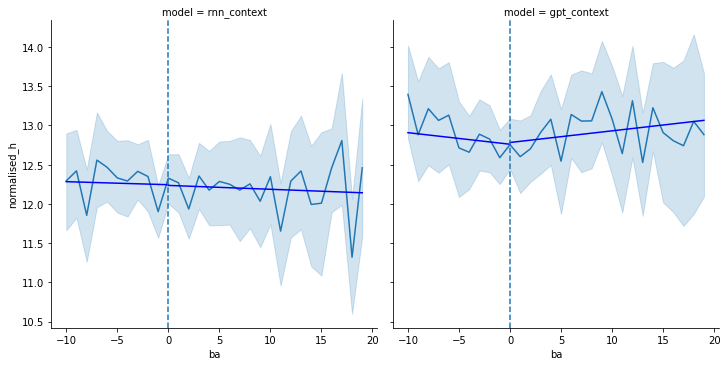

In [128]:
target_col = "normalised_h"
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model')
model_memory = {model:{} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        tmp = final_df[final_df.model == model].dropna(subset=[col])
        x = np.array([tmp['index'].min(), tmp['index'].max()])
        reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
        #print(model, col, reg_model.params) # .summary() for full summary of model
        g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], 'b')
        model_memory[model][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


In [153]:
model_memory

{'rnn_context': {'responder': {'count_before': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fb885d34350>}},
 'gpt_context': {'responder': {}}}

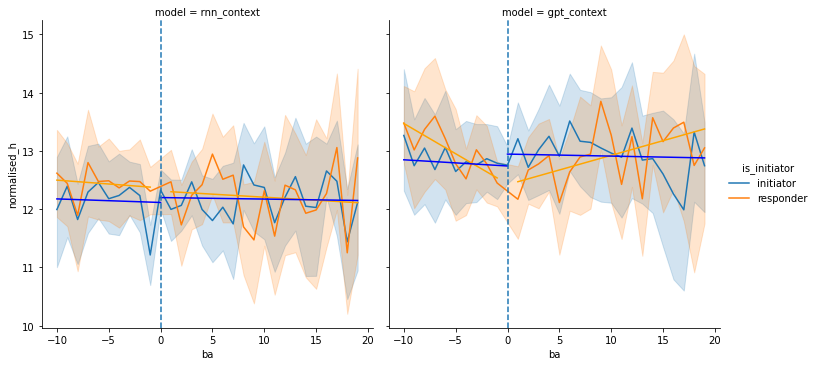

In [160]:
target_col = "normalised_h"
g = sns.relplot(data=final_df, x="ba", y=target_col, kind="line", col='model', hue='is_initiator')
model_memory = {model:{spk:{} for spk in ['initiator','responder']} for model in final_df.model.unique()}

for model in final_df.model.unique():
    for col in ['count_before', 'count_after']:
        for spk, c in zip(['responder', 'initiator'], ['orange', 'b']):
            tmp = final_df[(final_df.model == model) & (final_df.is_initiator == spk)].dropna(subset=[col])
            x = np.array([tmp['index'].min(), tmp['index'].max()])
            reg_model = sm.OLS(tmp[target_col], sm.add_constant(tmp[[col]])).fit()
            #print(model, col, reg_model.params) # .summary() for full summary of model
            g.axes_dict[model].plot(x, x*reg_model.params[col] + reg_model.params['const'], c)
            model_memory[model][spk][col] = reg_model

for ax in g.axes_dict.values():
    ax.axvline(x=0, linestyle='dashed')


<AxesSubplot:xlabel='ba', ylabel='xu_h'>

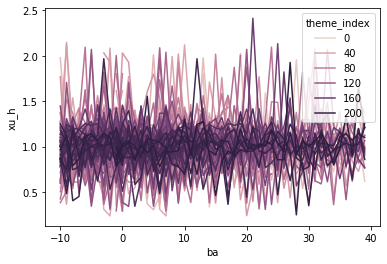

In [72]:
sns.lineplot(data=final_df, x="ba", y="xu_h", hue="theme_index")

<AxesSubplot:xlabel='ba', ylabel='xu_h_+1'>

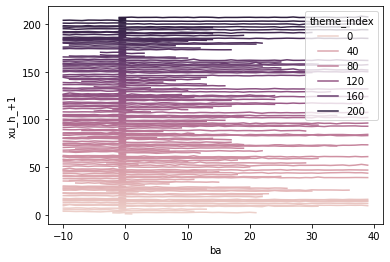

In [65]:
final_df['xu_h_+1'] = final_df.xu_h + final_df.theme_index
sns.lineplot(data=final_df, x="ba", y="xu_h_+1", hue="theme_index")

In [161]:
for spk in ['initiator','responder']:
    print(f'\n-------{spk}---------')
    print(model_memory['gpt_context'][spk]['count_after'].summary())


-------initiator---------
                            OLS Regression Results                            
Dep. Variable:           normalised_h   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04423
Date:                Tue, 22 Mar 2022   Prob (F-statistic):              0.833
Time:                        11:20:52   Log-Likelihood:                -2826.8
No. Observations:                1115   AIC:                             5658.
Df Residuals:                    1113   BIC:                             5668.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.9463 